,kappa,m_S,m_bar,chi,chi_bar,p,sparsity
0,0.000010,0.993291,0.993002,25572.336909,25839.792780,0.467093,0.467093
1,0.000023,0.993285,0.993345,25724.848059,25874.054199,0.407452,0.407452
2,0.000030,0.990543,0.989888,25739.086437,26062.716147,0.618398,0.618398
3,0.000051,0.993841,0.993687,25643.489855,25830.208499,0.530670,0.530670
4,0.000091,0.975125,0.974050,26370.092097,26504.021191,0.473520,0.473520


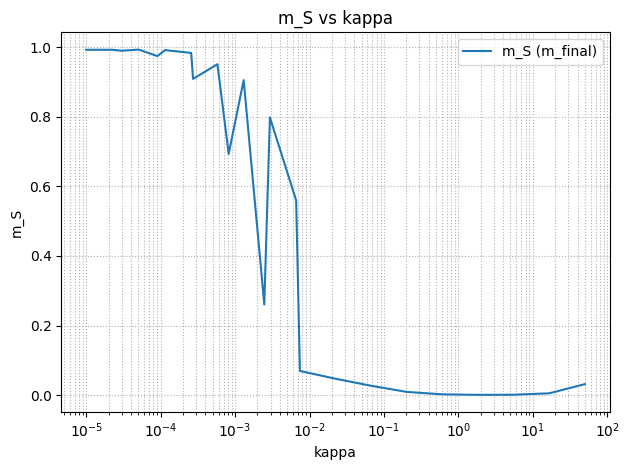

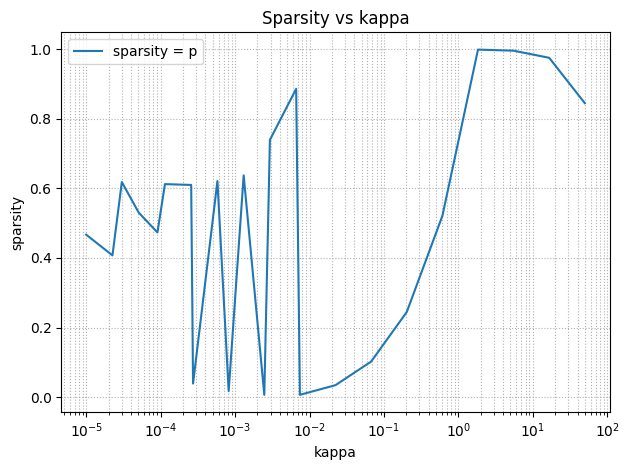

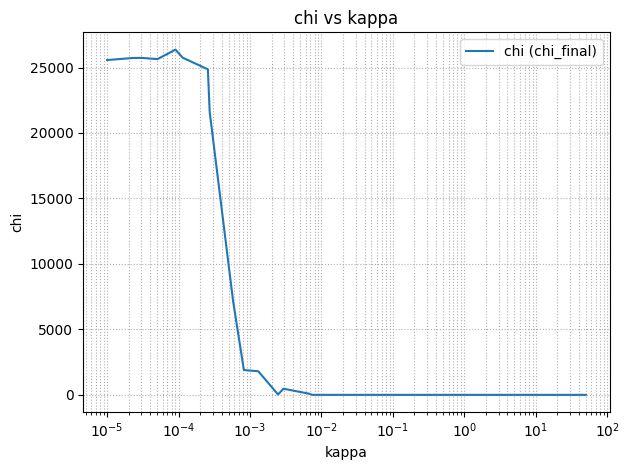

In [1]:
# --- Configure this to point at your results directory ---
DATA_DIR = "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/0708_d30k4_diagosntic4_mix3"

# If you want "sparsity" to mean 1 - p instead of p, set this to '1-p'
SPARSITY_MODE = 'p'   # options: 'p' or '1-p'

# ---------------------------------------------------------

import os, json, glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_results(data_dir: str) -> pd.DataFrame:
    # Grab all JSONs that look like your saved results
    pattern = str(Path(data_dir) / "**" / "saem_mix_result_*.json")
    files = glob.glob(pattern, recursive=True)
    if not files:
        raise FileNotFoundError(f"No result JSONs found under: {data_dir}")

    rows = []
    for fp in files:
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            # Only keep rows that have the essentials
            if all(k in obj for k in ("kappa", "m_final", "chi_final", "p_final")):
                rows.append({
                    "kappa": float(obj["kappa"]),
                    "m_S": float(obj["m_final"]),   # treat m_S as m_final
                    "m_bar": float(obj.get("m_bar", np.nan)),
                    "chi": float(obj["chi_final"]),
                    "chi_bar": float(obj.get("chi_bar", np.nan)),
                    "p": float(obj["p_final"]),
                    "path": fp
                })
        except Exception as e:
            print(f"Skipping {fp}: {e}")

    if not rows:
        raise RuntimeError("Found files, but none had the expected fields.")
    df = pd.DataFrame(rows)

    # If multiple files share the same kappa, average them (or choose another rule if you prefer)
    df = (df
          .groupby("kappa", as_index=False)
          .agg({"m_S":"mean","m_bar":"mean","chi":"mean","chi_bar":"mean","p":"mean"}))

    # Sort by kappa (your list is log-spaced)
    df = df.sort_values("kappa").reset_index(drop=True)
    return df

df = load_results(DATA_DIR)

# Add a "sparsity" column based on your preferred definition
if SPARSITY_MODE == '1-p':
    df["sparsity"] = 1.0 - df["p"]
else:
    df["sparsity"] = df["p"]

# Quick peek
display(df.head())

# ---------- Plot: m_S vs kappa ----------
plt.figure()
plt.plot(df["kappa"], df["m_S"], label="m_S (m_final)")
# If you want to see PR-averaged too, uncomment next line:
# plt.plot(df["kappa"], df["m_bar"], linestyle="--", label="m_bar")
plt.xscale("log")
plt.xlabel("kappa")
plt.ylabel("m_S")
plt.title("m_S vs kappa")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()

# ---------- Plot: sparsity vs kappa ----------
plt.figure()
plt.plot(df["kappa"], df["sparsity"], label=f"sparsity = {SPARSITY_MODE}")
plt.xscale("log")
plt.xlabel("kappa")
plt.ylabel("sparsity")
plt.title("Sparsity vs kappa")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()

# ---------- Plot: chi vs kappa ----------
plt.figure()
plt.plot(df["kappa"], df["chi"], label="chi (chi_final)")
# If you want to see PR-averaged too, uncomment next line:
# plt.plot(df["kappa"], df["chi_bar"], linestyle="--", label="chi_bar")
plt.xscale("log")
plt.xlabel("kappa")
plt.ylabel("chi")
plt.title("chi vs kappa")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()


AttributeError: 'XAxis' object has no attribute 'set_majorFormatter'

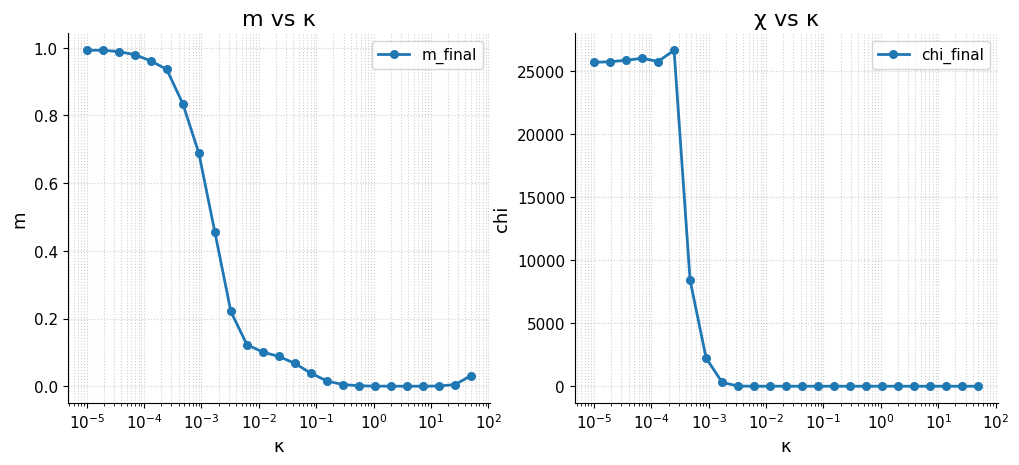

In [7]:
# === CONFIG: set your results dir ===
NOMIX_DIR = "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/0708_d30k4_nospecialst"

import os, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def load_nomix_results(results_dir: str) -> pd.DataFrame:
    files = glob.glob(os.path.join(results_dir, "**", "saem_nomix_result_*.json"), recursive=True)
    if not files:
        raise FileNotFoundError(f"No nomix JSONs found under: {results_dir}")
    rows = []
    for fp in files:
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            rows.append({
                "kappa": float(obj["kappa"]),
                "m": float(obj["m_final"]),
                "chi": float(obj["chi_final"]),
                "m_bar": float(obj.get("m_bar", np.nan)),
                "chi_bar": float(obj.get("chi_bar", np.nan)),
                "path": fp
            })
        except Exception as e:
            print(f"Skipping {fp}: {e}")
    df = pd.DataFrame(rows)
    df = (df.groupby("kappa", as_index=False)
            .agg({"m":"mean","chi":"mean","m_bar":"mean","chi_bar":"mean"}))
    return df.sort_values("kappa").reset_index(drop=True)

def plot_nomix(df: pd.DataFrame, logx=True, show_pr=False):
    plt.rcParams.update({
        "font.size": 12, "axes.labelsize": 13, "axes.titlesize": 16,
        "xtick.labelsize": 11, "ytick.labelsize": 11, "legend.fontsize": 11
    })
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), sharex=True)

    # m vs kappa
    axes[0].plot(df["kappa"], df["m"], "-o", label="m_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["m_bar"]).any():
        axes[0].plot(df["kappa"], df["m_bar"], "--o", label="m_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[0].set_ylabel("m")
    axes[0].set_title("m vs κ")
    axes[0].legend()

    # chi vs kappa
    axes[1].plot(df["kappa"], df["chi"], "-o", label="chi_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["chi_bar"]).any():
        axes[1].plot(df["kappa"], df["chi_bar"], "--o", label="chi_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[1].set_ylabel("chi")
    axes[1].set_title("χ vs κ")
    axes[1].legend()

    for ax in axes:
        if logx:
            ax.set_xscale("log")
        ax.set_xlabel("κ")
        ax.grid(True, which="both", linestyle=":", alpha=0.6)
        for s in ("top","right"):
            ax.spines[s].set_visible(False)

    if logx:
        def log_to_tex(v, pos):
            try:
                p = int(np.round(np.log10(v)))
                if np.isclose(10**p, v): return rf"$10^{p}$"
            except: pass
            return ""
        axes[1].xaxis.set_majorFormatter(FuncFormatter(log_to_tex))

    plt.tight_layout()
    plt.show()

# run
df_nomix = load_nomix_results(NOMIX_DIR)
plot_nomix(df_nomix, logx=True, show_pr=False)


AttributeError: 'XAxis' object has no attribute 'set_majorFormatter'

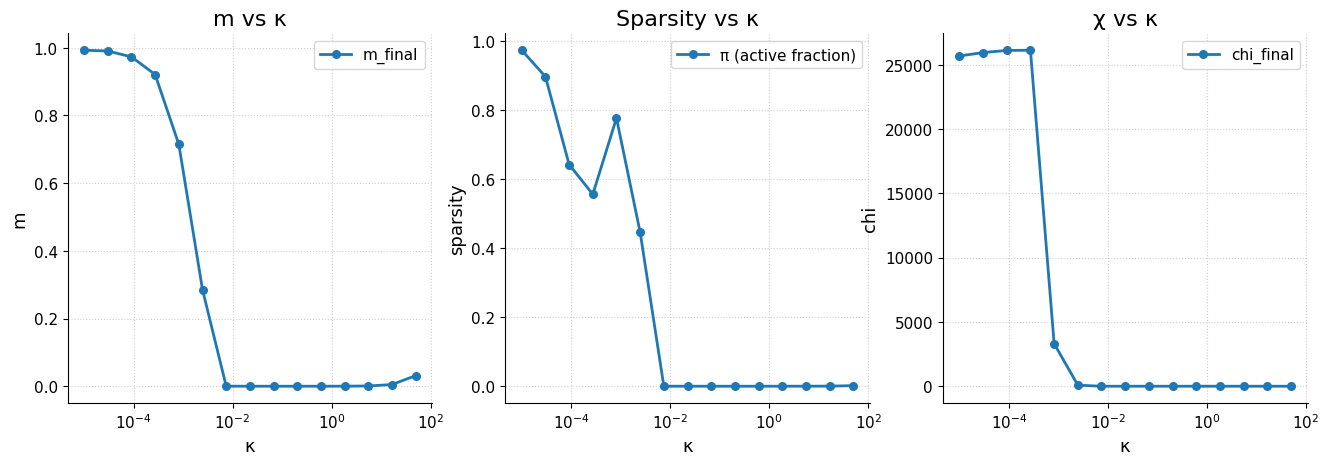

In [8]:
# === CONFIG: set your results dir ===
SPIKESLAB_DIR = "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/0708_d30k4_sparse"

# Choose how to show "sparsity": 'pi' (active fraction) or '1-pi' (inactive fraction)
SPARSITY_MODE = 'pi'   # options: 'pi' or '1-pi'

import os, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def load_spikeslab_results(results_dir: str) -> pd.DataFrame:
    files = glob.glob(os.path.join(results_dir, "**", "saem_spikeslab_result_*.json"), recursive=True)
    if not files:
        raise FileNotFoundError(f"No spikeslab JSONs found under: {results_dir}")
    rows = []
    for fp in files:
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            rows.append({
                "kappa": float(obj["kappa"]),
                "m": float(obj["m_final"]),
                "chi": float(obj["chi_final"]),
                "pi": float(obj["pi_final"]),
                "m_bar": float(obj.get("m_bar", np.nan)),
                "chi_bar": float(obj.get("chi_bar", np.nan)),
                "pi_bar": float(obj.get("pi_bar", np.nan)),
                "path": fp
            })
        except Exception as e:
            print(f"Skipping {fp}: {e}")
    df = pd.DataFrame(rows)
    df = (df.groupby("kappa", as_index=False)
            .agg({"m":"mean","chi":"mean","pi":"mean",
                  "m_bar":"mean","chi_bar":"mean","pi_bar":"mean"}))
    return df.sort_values("kappa").reset_index(drop=True)

def plot_spikeslab(df: pd.DataFrame, logx=True, show_pr=False, cmap_name="viridis"):
    plt.rcParams.update({
        "font.size": 12, "axes.labelsize": 13, "axes.titlesize": 16,
        "xtick.labelsize": 11, "ytick.labelsize": 11, "legend.fontsize": 11
    })
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), sharex=True)

    # m vs kappa
    axes[0].plot(df["kappa"], df["m"], "-o", label="m_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["m_bar"]).any():
        axes[0].plot(df["kappa"], df["m_bar"], "--o", label="m_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[0].set_ylabel("m")
    axes[0].set_title("m vs κ")
    axes[0].legend()

    # sparsity (π or 1-π) vs kappa
    if SPARSITY_MODE == '1-pi':
        sparsity = 1.0 - df["pi"].values
        label_main = "1 - π (inactive fraction)"
        if show_pr and np.isfinite(df["pi_bar"]).any():
            sparsity_bar = 1.0 - df["pi_bar"].values
            label_bar  = "1 - π_bar (PR avg)"
    else:
        sparsity = df["pi"].values
        label_main = "π (active fraction)"
        if show_pr and np.isfinite(df["pi_bar"]).any():
            sparsity_bar = df["pi_bar"].values
            label_bar    = "π_bar (PR avg)"

    axes[1].plot(df["kappa"], sparsity, "-o", label=label_main, linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df.get("pi_bar", np.nan)).any():
        axes[1].plot(df["kappa"], sparsity_bar, "--o", label=label_bar, linewidth=1.7, markersize=4.5)
    axes[1].set_ylabel("sparsity")
    axes[1].set_title("Sparsity vs κ")
    axes[1].legend()

    # chi vs kappa
    axes[2].plot(df["kappa"], df["chi"], "-o", label="chi_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["chi_bar"]).any():
        axes[2].plot(df["kappa"], df["chi_bar"], "--o", label="chi_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[2].set_ylabel("chi")
    axes[2].set_title("χ vs κ")
    axes[2].legend()

    for ax in axes:
        if logx:
            ax.set_xscale("log")
        ax.set_xlabel("κ")
        ax.grid(True, which="both", linestyle=":", alpha=0.6)
        for s in ("top","right"):
            ax.spines[s].set_visible(False)

    if logx:
        def log_to_tex(v, pos):
            try:
                p = int(np.round(np.log10(v)))
                if np.isclose(10**p, v): return rf"$10^{p}$"
            except: pass
            return ""
        axes[2].xaxis.set_majorFormatter(FuncFormatter(log_to_tex))

    plt.tight_layout()
    plt.show()

# run
df_spike = load_spikeslab_results(SPIKESLAB_DIR)
plot_spikeslab(df_spike, logx=True, show_pr=False)


AttributeError: 'XAxis' object has no attribute 'set_majorFormatter'

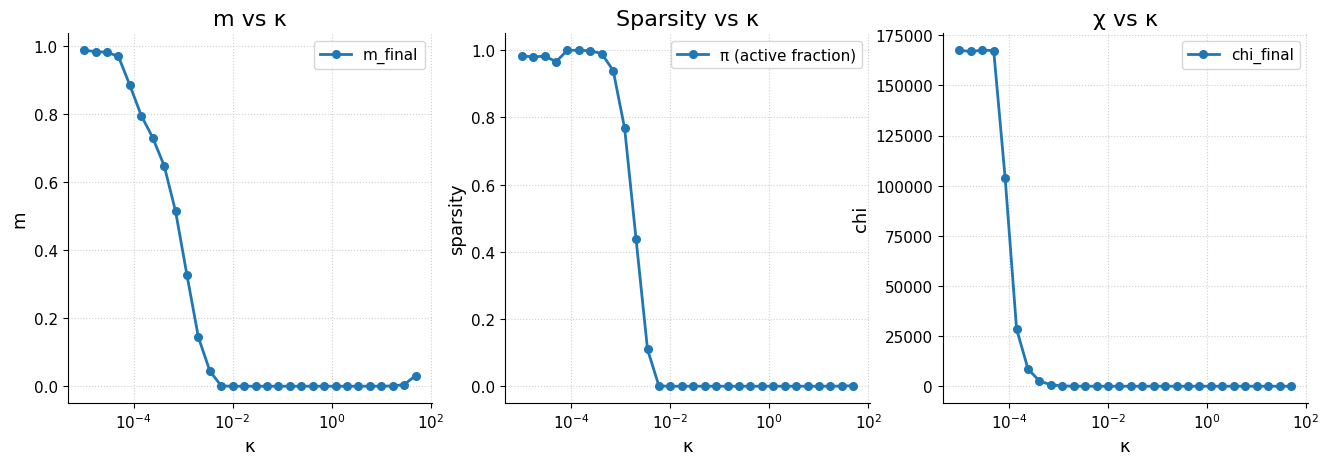

In [1]:
# === CONFIG: set your results dir ===
SPIKESLAB_DIR = "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/0708_d50k6_sparse"

# Choose how to show "sparsity": 'pi' (active fraction) or '1-pi' (inactive fraction)
SPARSITY_MODE = 'pi'   # options: 'pi' or '1-pi'

import os, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def load_spikeslab_results(results_dir: str) -> pd.DataFrame:
    files = glob.glob(os.path.join(results_dir, "**", "saem_spikeslab_result_*.json"), recursive=True)
    if not files:
        raise FileNotFoundError(f"No spikeslab JSONs found under: {results_dir}")
    rows = []
    for fp in files:
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            rows.append({
                "kappa": float(obj["kappa"]),
                "m": float(obj["m_final"]),
                "chi": float(obj["chi_final"]),
                "pi": float(obj["pi_final"]),
                "m_bar": float(obj.get("m_bar", np.nan)),
                "chi_bar": float(obj.get("chi_bar", np.nan)),
                "pi_bar": float(obj.get("pi_bar", np.nan)),
                "path": fp
            })
        except Exception as e:
            print(f"Skipping {fp}: {e}")
    df = pd.DataFrame(rows)
    df = (df.groupby("kappa", as_index=False)
            .agg({"m":"mean","chi":"mean","pi":"mean",
                  "m_bar":"mean","chi_bar":"mean","pi_bar":"mean"}))
    return df.sort_values("kappa").reset_index(drop=True)

def plot_spikeslab(df: pd.DataFrame, logx=True, show_pr=False, cmap_name="viridis"):
    plt.rcParams.update({
        "font.size": 12, "axes.labelsize": 13, "axes.titlesize": 16,
        "xtick.labelsize": 11, "ytick.labelsize": 11, "legend.fontsize": 11
    })
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), sharex=True)

    # m vs kappa
    axes[0].plot(df["kappa"], df["m"], "-o", label="m_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["m_bar"]).any():
        axes[0].plot(df["kappa"], df["m_bar"], "--o", label="m_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[0].set_ylabel("m")
    axes[0].set_title("m vs κ")
    axes[0].legend()

    # sparsity (π or 1-π) vs kappa
    if SPARSITY_MODE == '1-pi':
        sparsity = 1.0 - df["pi"].values
        label_main = "1 - π (inactive fraction)"
        if show_pr and np.isfinite(df["pi_bar"]).any():
            sparsity_bar = 1.0 - df["pi_bar"].values
            label_bar  = "1 - π_bar (PR avg)"
    else:
        sparsity = df["pi"].values
        label_main = "π (active fraction)"
        if show_pr and np.isfinite(df["pi_bar"]).any():
            sparsity_bar = df["pi_bar"].values
            label_bar    = "π_bar (PR avg)"

    axes[1].plot(df["kappa"], sparsity, "-o", label=label_main, linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df.get("pi_bar", np.nan)).any():
        axes[1].plot(df["kappa"], sparsity_bar, "--o", label=label_bar, linewidth=1.7, markersize=4.5)
    axes[1].set_ylabel("sparsity")
    axes[1].set_title("Sparsity vs κ")
    axes[1].legend()

    # chi vs kappa
    axes[2].plot(df["kappa"], df["chi"], "-o", label="chi_final", linewidth=2.0, markersize=5.5)
    if show_pr and np.isfinite(df["chi_bar"]).any():
        axes[2].plot(df["kappa"], df["chi_bar"], "--o", label="chi_bar (PR avg)", linewidth=1.7, markersize=4.5)
    axes[2].set_ylabel("chi")
    axes[2].set_title("χ vs κ")
    axes[2].legend()

    for ax in axes:
        if logx:
            ax.set_xscale("log")
        ax.set_xlabel("κ")
        ax.grid(True, which="both", linestyle=":", alpha=0.6)
        for s in ("top","right"):
            ax.spines[s].set_visible(False)

    if logx:
        def log_to_tex(v, pos):
            try:
                p = int(np.round(np.log10(v)))
                if np.isclose(10**p, v): return rf"$10^{p}$"
            except: pass
            return ""
        axes[2].xaxis.set_majorFormatter(FuncFormatter(log_to_tex))

    plt.tight_layout()
    plt.show()

# run
df_spike = load_spikeslab_results(SPIKESLAB_DIR)
plot_spikeslab(df_spike, logx=True, show_pr=False)


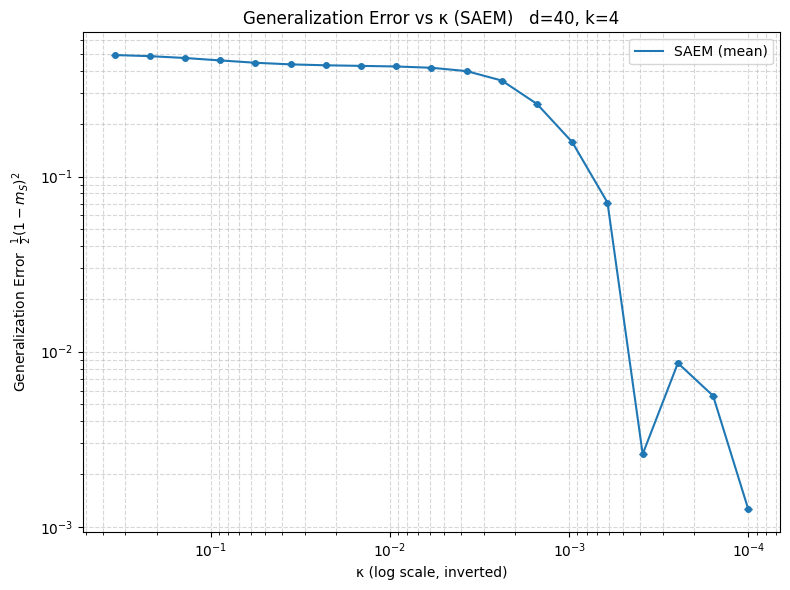

In [28]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- set this to your SAEM results directory ---
results_dir = Path("/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/1808_d40k4_nospecialst")

def load_saem_results(results_dir: Path) -> pd.DataFrame:
    """
    Load SAEM JSON snapshots and compute GE = 0.5 * (1 - m_final)^2.
    """
    rows = []
    for f in results_dir.rglob("saem_nomix_result_*.json"):
        try:
            with open(f, "r") as fh:
                data = json.load(fh)
        except json.JSONDecodeError:
            print(f"⚠️ Could not parse {f}")
            continue

        kappa = data.get("kappa", None)
        m_final = data.get("m_final", None)
        if kappa is None or m_final is None:
            continue

        kappa = float(kappa)
        m_final = float(m_final)
        ge = 0.5 * (1.0 - m_final) ** 2

        row = {"kappa": kappa, "m_final": m_final, "gene_error": ge, "path": str(f)}
        base = data.get("BASE", {})
        for key in ("d", "k", "N", "σa", "σw", "γ", "act"):
            if key in base:
                row[key] = base[key]
        rows.append(row)

    df = pd.DataFrame(rows)
    if df.empty:
        print("No SAEM results found.")
        return df

    df["kappa"] = pd.to_numeric(df["kappa"], errors="coerce")
    df["gene_error"] = pd.to_numeric(df["gene_error"], errors="coerce")
    df = df.dropna(subset=["kappa", "gene_error"])
    df["kappa_rounded"] = df["kappa"].round(12)
    return df

def plot_gene_error_saem(results_dir: Path):
    df = load_saem_results(results_dir)
    if df.empty:
        return

    has_dk = ("d" in df.columns) and ("k" in df.columns)
    groups = df.groupby(["d", "k"]) if has_dk else [((None, None), df)]

    for (d, k), df_sub in groups:
        grp = df_sub.groupby("kappa_rounded")["gene_error"]
        means = grp.mean().rename("mean")
        stds  = grp.std(ddof=1).rename("std")
        ns    = grp.count().rename("n")
        sems  = (stds / np.sqrt(ns)).rename("sem")

        agg = pd.concat([means, stds, sems, ns], axis=1).reset_index()
        agg = agg.sort_values("kappa_rounded")

        fig, ax = plt.subplots(figsize=(8, 6))

        (line,) = ax.plot(agg["kappa_rounded"].to_numpy(),
                          agg["mean"].to_numpy(),
                          label="SAEM (mean)")
        color = line.get_color()

        upper = agg["mean"] + agg["sem"].fillna(0)
        lower = agg["mean"] - agg["sem"].fillna(0)
        ax.fill_between(agg["kappa_rounded"].to_numpy(),
                        lower.to_numpy(),
                        upper.to_numpy(),
                        alpha=0.2)

        ax.errorbar(agg["kappa_rounded"].to_numpy(),
                    agg["mean"].to_numpy(),
                    yerr=agg["sem"].fillna(0).to_numpy(),
                    fmt="o", ms=4, lw=1, capsize=3, color=color, ecolor=color)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.invert_xaxis()
        ax.set_xlabel("κ (log scale, inverted)")
        # FIXED: use \frac (mathtext supports it), not \tfrac
        try:
            ax.set_ylabel(r"Generalization Error  $\frac{1}{2}(1 - m_S)^2$")
        except ValueError:
            # Fallback if mathtext not available
            ax.set_ylabel("Generalization Error  0.5·(1 - m_S)^2")

        title = "Generalization Error vs κ (SAEM)"
        if d is not None and k is not None:
            title += f"   d={int(d)}, k={int(k)}"
        ax.set_title(title)

        ax.grid(True, which="both", ls="--", alpha=0.5)
        ax.legend()
        plt.tight_layout()
        plt.show()

# run
plot_gene_error_saem(results_dir)


Loaded 12 JSON files with kappa & m_final


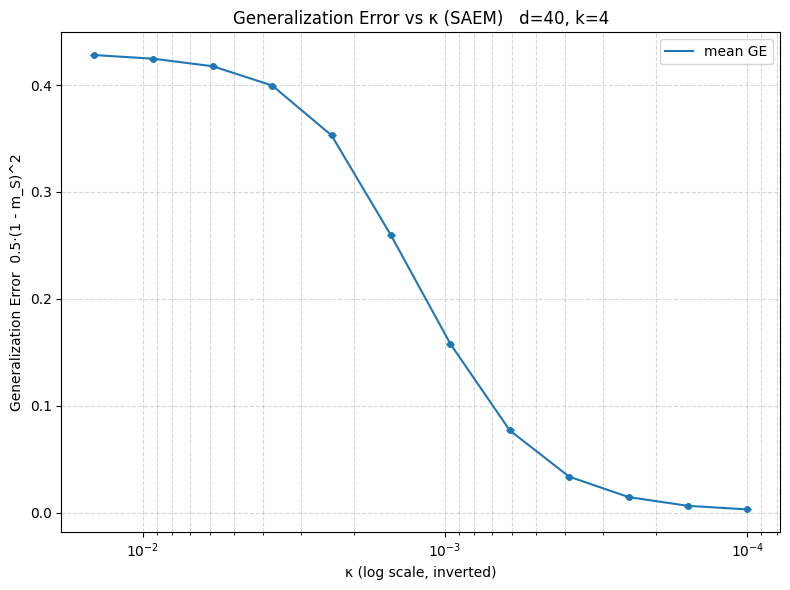

In [17]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- point this to the directory that contains your JSON results (any of the 3 scripts) ---
results_dir = Path("/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/1808_d40k4_nospecialst_infN")

def load_ge_from_results(root: Path) -> pd.DataFrame:
    """
    Scan recursively for *.json. Keep only files whose top-level JSON is a dict
    with numeric 'kappa' and 'm_final'. Compute GE = 0.5 * (1 - m_final)^2.
    """
    rows = []
    for f in root.rglob("*.json"):
        try:
            with open(f, "r") as fh:
                data = json.load(fh)
        except Exception:
            continue  # skip unreadable / partial logs

        if not isinstance(data, dict):
            continue
        if "kappa" not in data or "m_final" not in data:
            continue

        try:
            kappa = float(data["kappa"])
            m_final = float(data["m_final"])
        except (TypeError, ValueError):
            continue

        ge = 0.5 * (1.0 - m_final) ** 2  # <-- κ-independent GE

        row = {"kappa": kappa, "m_final": m_final, "gene_error": ge, "path": str(f)}
        base = data.get("BASE", {})
        # capture d,k if present for per-(d,k) plots
        if isinstance(base, dict):
            for key in ("d", "k"):
                if key in base:
                    try:
                        row[key] = int(base[key])
                    except Exception:
                        pass
        rows.append(row)

    df = pd.DataFrame(rows)
    if df.empty:
        print("No usable SAEM results found (need top-level 'kappa' and 'm_final').")
        return df

    # numeric & stable grouping
    df["kappa"] = pd.to_numeric(df["kappa"], errors="coerce")
    df["gene_error"] = pd.to_numeric(df["gene_error"], errors="coerce")
    df = df.dropna(subset=["kappa", "gene_error"]).copy()
    df["kappa_rounded"] = df["kappa"].round(12)
    return df

def plot_ge(df: pd.DataFrame) -> None:
    """
    Plot GE vs κ (log-scale, inverted):
      - line (mean across runs at same κ)
      - circular mean points
      - shaded ribbon = ±1 SEM
    One figure per (d,k) if present; otherwise one figure.
    """
    if df.empty:
        return

    has_dk = ("d" in df.columns) and ("k" in df.columns)
    group_iter = df.groupby(["d", "k"]) if has_dk else [((None, None), df)]

    for (d, k), g in group_iter:
        # aggregate duplicates at same κ
        grouped = g.groupby("kappa_rounded")["gene_error"]
        means = grouped.mean()
        # use ddof=0 so SEM is 0 when n=1
        stds  = grouped.std(ddof=0)
        ns    = grouped.count()
        sems  = stds / np.sqrt(ns)

        agg = (
            pd.DataFrame({
                "kappa": means.index.values,
                "mean": means.values,
                "sem": sems.values,
                "n": ns.values,
            })
            .sort_values("kappa")
            .reset_index(drop=True)
        )

        fig, ax = plt.subplots(figsize=(8, 6))

        # line
        (line,) = ax.plot(agg["kappa"].to_numpy(),
                          agg["mean"].to_numpy(),
                          label="mean GE")
        color = line.get_color()

        # ribbon ±1 SEM
        upper = agg["mean"] + agg["sem"]
        lower = agg["mean"] - agg["sem"]
        ax.fill_between(agg["kappa"].to_numpy(),
                        lower.to_numpy(),
                        upper.to_numpy(),
                        alpha=0.2)

        # points + vertical error bars (SEM)
        ax.errorbar(agg["kappa"].to_numpy(),
                    agg["mean"].to_numpy(),
                    yerr=agg["sem"].to_numpy(),
                    fmt="o", ms=4, lw=1, capsize=3, color=color, ecolor=color)

        ax.set_xscale("log")
        ax.invert_xaxis()
        ax.set_xlabel("κ (log scale, inverted)")
        ax.set_ylabel("Generalization Error  0.5·(1 - m_S)^2")  # plain text to avoid LaTeX issues

        title = "Generalization Error vs κ (SAEM)"
        if d is not None and k is not None:
            title += f"   d={d}, k={k}"
        ax.set_title(title)

        ax.grid(True, which="both", ls="--", alpha=0.5)
        ax.legend()
        plt.tight_layout()
        plt.show()

# --- run ---
df_ge = load_ge_from_results(results_dir)
print(f"Loaded {len(df_ge)} JSON files with kappa & m_final")
plot_ge(df_ge)


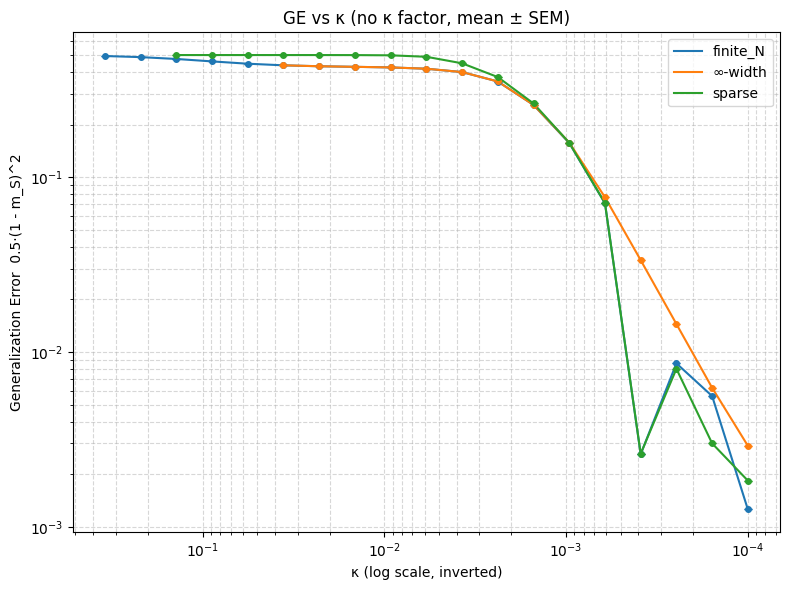

In [32]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_ge_from_results(root: Path) -> pd.DataFrame:
    """
    Recursively scan 'root' for *.json, keep those with top-level numeric
    'kappa' and 'm_final'. Compute GE = 0.5 * (1 - m_final)^2.
    Returns DataFrame with columns: kappa, gene_error.
    """
    rows = []
    for f in Path(root).rglob("*.json"):
        try:
            with open(f, "r") as fh:
                data = json.load(fh)
        except Exception:
            continue
        if not isinstance(data, dict):
            continue
        if "kappa" not in data or "m_final" not in data:
            continue
        try:
            kappa = float(data["kappa"])
            m_final = float(data["m_final"])
        except (TypeError, ValueError):
            continue

        ge = 0.5 * (1.0 - m_final) ** 2  # κ-independent GE

        rows.append({"kappa": kappa, "gene_error": ge})

    df = pd.DataFrame(rows)
    if df.empty:
        return df
    df["kappa"] = pd.to_numeric(df["kappa"], errors="coerce")
    df["gene_error"] = pd.to_numeric(df["gene_error"], errors="coerce")
    df = df.dropna(subset=["kappa", "gene_error"]).copy()
    df["kappa_rounded"] = df["kappa"].round(12)
    return df

def aggregate_by_kappa(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate mean and SEM of GE at each κ.
    ddof=0 so std(1 sample)=0 -> SEM=0.
    """
    grouped = df.groupby("kappa_rounded")["gene_error"]
    means = grouped.mean()
    stds  = grouped.std(ddof=0)
    ns    = grouped.count()
    sems  = stds / np.sqrt(ns)

    agg = (
        pd.DataFrame({
            "kappa": means.index.values,
            "mean": means.values,
            "sem": sems.values,
            "n": ns.values,
        })
        .sort_values("kappa")
        .reset_index(drop=True)
    )
    return agg

def plot_ge_overlay(paths, labels, title="Generalization Error vs κ (overlay)"):
    """
    Overlay GE(κ) from multiple result directories on one plot.

    Args:
        paths  : list of str/Path directories (each containing your SAEM JSONs)
        labels : list of legend labels, same length as 'paths'
    """
    if len(paths) != len(labels):
        raise ValueError("paths and labels must have the same length.")

    fig, ax = plt.subplots(figsize=(8, 6))

    for path, label in zip(paths, labels):
        df = load_ge_from_results(Path(path))
        if df.empty:
            print(f"⚠️ No usable results in: {path}")
            continue
        agg = aggregate_by_kappa(df)

        # line
        (line,) = ax.plot(agg["kappa"].to_numpy(),
                          agg["mean"].to_numpy(),
                          label=label)
        color = line.get_color()

        # ribbon ±1 SEM
        upper = agg["mean"] + agg["sem"]
        lower = agg["mean"] - agg["sem"]
        ax.fill_between(agg["kappa"].to_numpy(),
                        lower.to_numpy(),
                        upper.to_numpy(),
                        alpha=0.2)

        # points + vertical error bars (SEM)
        ax.errorbar(agg["kappa"].to_numpy(),
                    agg["mean"].to_numpy(),
                    yerr=agg["sem"].to_numpy(),
                    fmt="o", ms=4, lw=1, capsize=3, color=color, ecolor=color)

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.invert_xaxis()
    ax.set_xlabel("κ (log scale, inverted)")
    ax.set_ylabel("Generalization Error  0.5·(1 - m_S)^2")
    ax.set_title(title)
    ax.grid(True, which="both", ls="--", alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ----------------- Example usage -----------------
paths = [
    "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/1808_d40k4_nospecialst",          # nomix
    "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/1808_d40k4_nospecialst_infN",      # inf-width
    "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/1808_d40k4_nospecialst_sparse",    # spike&slab
]
labels = ["finite_N", "∞-width", "sparse"]

plot_ge_overlay(paths, labels, title="GE vs κ (no κ factor, mean ± SEM)")


Loaded 11 JSON files with kappa & m_final


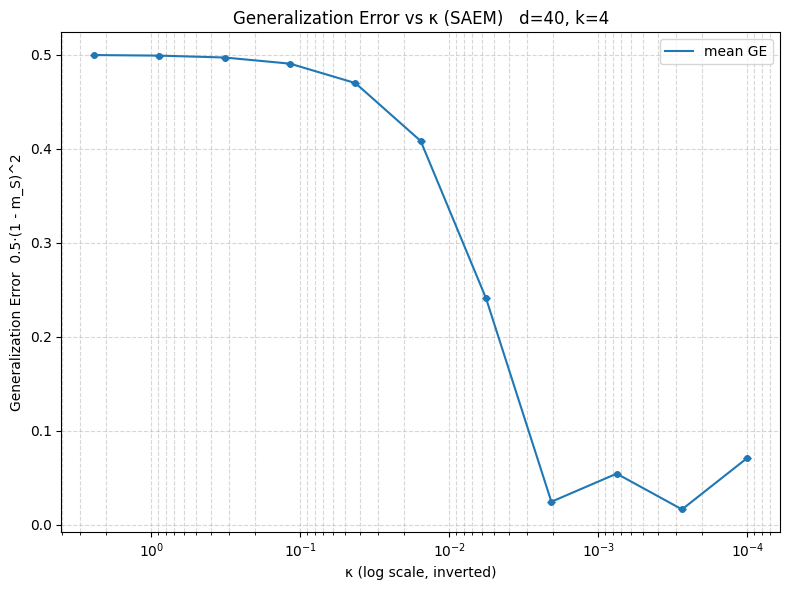

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- point this to the directory that contains your JSON results (any of the 3 scripts) ---
results_dir = Path("/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/1808_d40k4_nospecialst_matchingexp")

def load_ge_from_results(root: Path) -> pd.DataFrame:
    """
    Scan recursively for *.json. Keep only files whose top-level JSON is a dict
    with numeric 'kappa' and 'm_final'. Compute GE = 0.5 * (1 - m_final)^2.
    """
    rows = []
    for f in root.rglob("*.json"):
        try:
            with open(f, "r") as fh:
                data = json.load(fh)
        except Exception:
            continue  # skip unreadable / partial logs

        if not isinstance(data, dict):
            continue
        if "kappa" not in data or "m_final" not in data:
            continue

        try:
            kappa = float(data["kappa"])
            m_final = float(data["m_final"])
        except (TypeError, ValueError):
            continue

        ge = 0.5 * (1.0 - m_final) ** 2  # <-- κ-independent GE

        row = {"kappa": kappa, "m_final": m_final, "gene_error": ge, "path": str(f)}
        base = data.get("BASE", {})
        # capture d,k if present for per-(d,k) plots
        if isinstance(base, dict):
            for key in ("d", "k"):
                if key in base:
                    try:
                        row[key] = int(base[key])
                    except Exception:
                        pass
        rows.append(row)

    df = pd.DataFrame(rows)
    if df.empty:
        print("No usable SAEM results found (need top-level 'kappa' and 'm_final').")
        return df

    # numeric & stable grouping
    df["kappa"] = pd.to_numeric(df["kappa"], errors="coerce")
    df["gene_error"] = pd.to_numeric(df["gene_error"], errors="coerce")
    df = df.dropna(subset=["kappa", "gene_error"]).copy()
    df["kappa_rounded"] = df["kappa"].round(12)
    return df

def plot_ge(df: pd.DataFrame) -> None:
    """
    Plot GE vs κ (log-scale, inverted):
      - line (mean across runs at same κ)
      - circular mean points
      - shaded ribbon = ±1 SEM
    One figure per (d,k) if present; otherwise one figure.
    """
    if df.empty:
        return

    has_dk = ("d" in df.columns) and ("k" in df.columns)
    group_iter = df.groupby(["d", "k"]) if has_dk else [((None, None), df)]

    for (d, k), g in group_iter:
        # aggregate duplicates at same κ
        grouped = g.groupby("kappa_rounded")["gene_error"]
        means = grouped.mean()
        # use ddof=0 so SEM is 0 when n=1
        stds  = grouped.std(ddof=0)
        ns    = grouped.count()
        sems  = stds / np.sqrt(ns)

        agg = (
            pd.DataFrame({
                "kappa": means.index.values,
                "mean": means.values,
                "sem": sems.values,
                "n": ns.values,
            })
            .sort_values("kappa")
            .reset_index(drop=True)
        )

        fig, ax = plt.subplots(figsize=(8, 6))

        # line
        (line,) = ax.plot(agg["kappa"].to_numpy(),
                          agg["mean"].to_numpy(),
                          label="mean GE")
        color = line.get_color()

        # ribbon ±1 SEM
        upper = agg["mean"] + agg["sem"]
        lower = agg["mean"] - agg["sem"]
        ax.fill_between(agg["kappa"].to_numpy(),
                        lower.to_numpy(),
                        upper.to_numpy(),
                        alpha=0.2)

        # points + vertical error bars (SEM)
        ax.errorbar(agg["kappa"].to_numpy(),
                    agg["mean"].to_numpy(),
                    yerr=agg["sem"].to_numpy(),
                    fmt="o", ms=4, lw=1, capsize=3, color=color, ecolor=color)

        ax.set_xscale("log")
        ax.invert_xaxis()
        ax.set_xlabel("κ (log scale, inverted)")
        ax.set_ylabel("Generalization Error  0.5·(1 - m_S)^2")  # plain text to avoid LaTeX issues

        title = "Generalization Error vs κ (SAEM)"
        if d is not None and k is not None:
            title += f"   d={d}, k={k}"
        ax.set_title(title)

        ax.grid(True, which="both", ls="--", alpha=0.5)
        ax.legend()
        plt.tight_layout()
        plt.show()

# --- run ---
df_ge = load_ge_from_results(results_dir)
print(f"Loaded {len(df_ge)} JSON files with kappa & m_final")
plot_ge(df_ge)


Loaded 15 JSON files with kappa & m_final


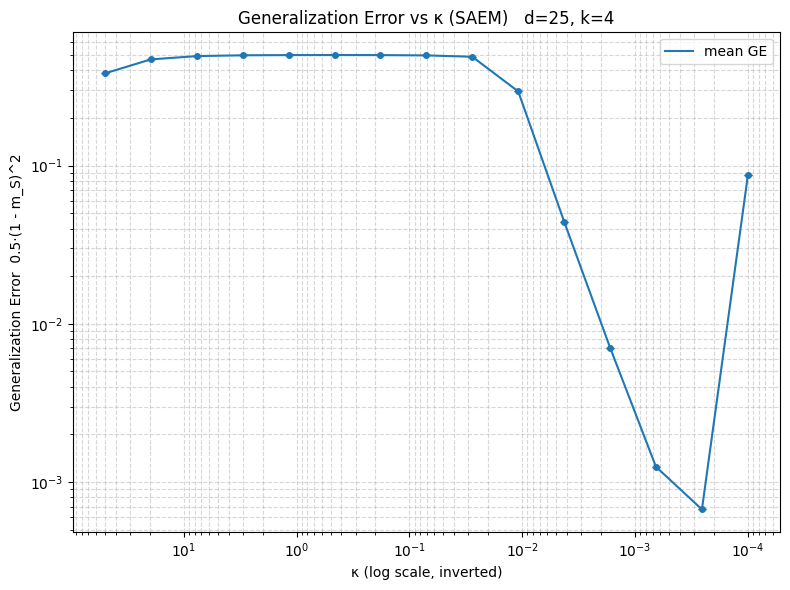

In [4]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- point this to the directory that contains your JSON results (any of the 3 scripts) ---
results_dir = Path("/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/1808_d25k4_nospecialst_fast")

def load_ge_from_results(root: Path) -> pd.DataFrame:
    """
    Scan recursively for *.json. Keep only files whose top-level JSON is a dict
    with numeric 'kappa' and 'm_final'. Compute GE = 0.5 * (1 - m_final)^2.
    """
    rows = []
    for f in root.rglob("*.json"):
        try:
            with open(f, "r") as fh:
                data = json.load(fh)
        except Exception:
            continue  # skip unreadable / partial logs

        if not isinstance(data, dict):
            continue
        if "kappa" not in data or "m_final" not in data:
            continue

        try:
            kappa = float(data["kappa"])
            m_final = float(data["m_final"])
        except (TypeError, ValueError):
            continue

        ge = 0.5 * (1.0 - m_final) ** 2  # <-- κ-independent GE

        row = {"kappa": kappa, "m_final": m_final, "gene_error": ge, "path": str(f)}
        base = data.get("BASE", {})
        # capture d,k if present for per-(d,k) plots
        if isinstance(base, dict):
            for key in ("d", "k"):
                if key in base:
                    try:
                        row[key] = int(base[key])
                    except Exception:
                        pass
        rows.append(row)

    df = pd.DataFrame(rows)
    if df.empty:
        print("No usable SAEM results found (need top-level 'kappa' and 'm_final').")
        return df

    # numeric & stable grouping
    df["kappa"] = pd.to_numeric(df["kappa"], errors="coerce")
    df["gene_error"] = pd.to_numeric(df["gene_error"], errors="coerce")
    df = df.dropna(subset=["kappa", "gene_error"]).copy()
    df["kappa_rounded"] = df["kappa"].round(12)
    return df

def plot_ge(df: pd.DataFrame) -> None:
    """
    Plot GE vs κ (log-scale, inverted):
      - line (mean across runs at same κ)
      - circular mean points
      - shaded ribbon = ±1 SEM
    One figure per (d,k) if present; otherwise one figure.
    """
    if df.empty:
        return

    has_dk = ("d" in df.columns) and ("k" in df.columns)
    group_iter = df.groupby(["d", "k"]) if has_dk else [((None, None), df)]

    for (d, k), g in group_iter:
        # aggregate duplicates at same κ
        grouped = g.groupby("kappa_rounded")["gene_error"]
        means = grouped.mean()
        # use ddof=0 so SEM is 0 when n=1
        stds  = grouped.std(ddof=0)
        ns    = grouped.count()
        sems  = stds / np.sqrt(ns)

        agg = (
            pd.DataFrame({
                "kappa": means.index.values,
                "mean": means.values,
                "sem": sems.values,
                "n": ns.values,
            })
            .sort_values("kappa")
            .reset_index(drop=True)
        )

        fig, ax = plt.subplots(figsize=(8, 6))

        # line
        (line,) = ax.plot(agg["kappa"].to_numpy(),
                          agg["mean"].to_numpy(),
                          label="mean GE")
        color = line.get_color()

        # ribbon ±1 SEM
        upper = agg["mean"] + agg["sem"]
        lower = agg["mean"] - agg["sem"]
        ax.fill_between(agg["kappa"].to_numpy(),
                        lower.to_numpy(),
                        upper.to_numpy(),
                        alpha=0.2)

        # points + vertical error bars (SEM)
        ax.errorbar(agg["kappa"].to_numpy(),
                    agg["mean"].to_numpy(),
                    yerr=agg["sem"].to_numpy(),
                    fmt="o", ms=4, lw=1, capsize=3, color=color, ecolor=color)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.invert_xaxis()
        ax.set_xlabel("κ (log scale, inverted)")
        ax.set_ylabel("Generalization Error  0.5·(1 - m_S)^2")  # plain text to avoid LaTeX issues

        title = "Generalization Error vs κ (SAEM)"
        if d is not None and k is not None:
            title += f"   d={d}, k={k}"
        ax.set_title(title)

        ax.grid(True, which="both", ls="--", alpha=0.5)
        ax.legend()
        plt.tight_layout()
        plt.show()

# --- run ---
df_ge = load_ge_from_results(results_dir)
print(f"Loaded {len(df_ge)} JSON files with kappa & m_final")
plot_ge(df_ge)


⚠️ No usable results in: /home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/2008_d25k4_infm2_nn


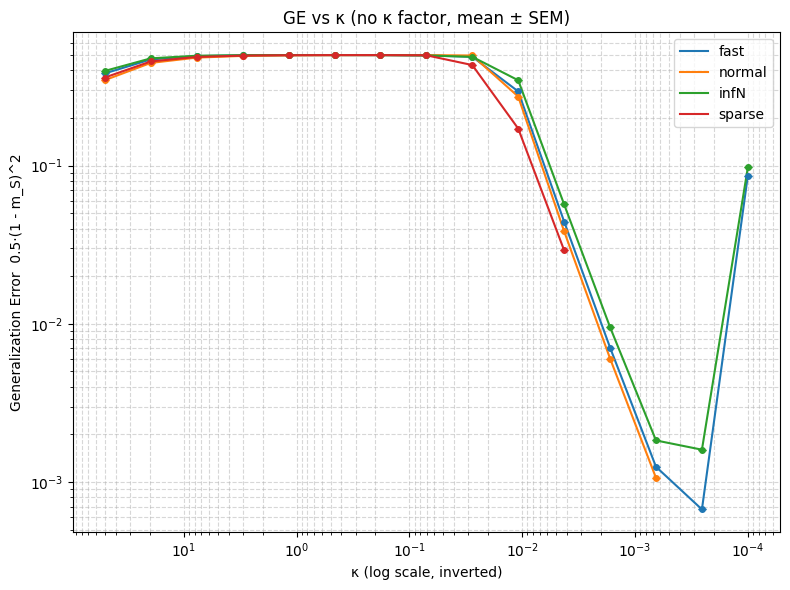

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_ge_from_results(root: Path) -> pd.DataFrame:
    """
    Recursively scan 'root' for *.json, keep those with top-level numeric
    'kappa' and 'm_final'. Compute GE = 0.5 * (1 - m_final)^2.
    Returns DataFrame with columns: kappa, gene_error.
    """
    rows = []
    for f in Path(root).rglob("*.json"):
        try:
            with open(f, "r") as fh:
                data = json.load(fh)
        except Exception:
            continue
        if not isinstance(data, dict):
            continue
        if "kappa" not in data or "m_final" not in data:
            continue
        try:
            kappa = float(data["kappa"])
            m_final = float(data["m_final"])
        except (TypeError, ValueError):
            continue

        ge = 0.5 * (1.0 - m_final) ** 2  # κ-independent GE

        rows.append({"kappa": kappa, "gene_error": ge})

    df = pd.DataFrame(rows)
    if df.empty:
        return df
    df["kappa"] = pd.to_numeric(df["kappa"], errors="coerce")
    df["gene_error"] = pd.to_numeric(df["gene_error"], errors="coerce")
    df = df.dropna(subset=["kappa", "gene_error"]).copy()
    df["kappa_rounded"] = df["kappa"].round(12)
    return df

def aggregate_by_kappa(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate mean and SEM of GE at each κ.
    ddof=0 so std(1 sample)=0 -> SEM=0.
    """
    grouped = df.groupby("kappa_rounded")["gene_error"]
    means = grouped.mean()
    stds  = grouped.std(ddof=0)
    ns    = grouped.count()
    sems  = stds / np.sqrt(ns)

    agg = (
        pd.DataFrame({
            "kappa": means.index.values,
            "mean": means.values,
            "sem": sems.values,
            "n": ns.values,
        })
        .sort_values("kappa")
        .reset_index(drop=True)
    )
    return agg

def plot_ge_overlay(paths, labels, title="Generalization Error vs κ (overlay)"):
    """
    Overlay GE(κ) from multiple result directories on one plot.

    Args:
        paths  : list of str/Path directories (each containing your SAEM JSONs)
        labels : list of legend labels, same length as 'paths'
    """
    if len(paths) != len(labels):
        raise ValueError("paths and labels must have the same length.")

    fig, ax = plt.subplots(figsize=(8, 6))

    for path, label in zip(paths, labels):
        df = load_ge_from_results(Path(path))
        if df.empty:
            print(f"⚠️ No usable results in: {path}")
            continue
        agg = aggregate_by_kappa(df)

        # line
        (line,) = ax.plot(agg["kappa"].to_numpy(),
                          agg["mean"].to_numpy(),
                          label=label)
        color = line.get_color()

        # ribbon ±1 SEM
        upper = agg["mean"] + agg["sem"]
        lower = agg["mean"] - agg["sem"]
        ax.fill_between(agg["kappa"].to_numpy(),
                        lower.to_numpy(),
                        upper.to_numpy(),
                        alpha=0.2)

        # points + vertical error bars (SEM)
        ax.errorbar(agg["kappa"].to_numpy(),
                    agg["mean"].to_numpy(),
                    yerr=agg["sem"].to_numpy(),
                    fmt="o", ms=4, lw=1, capsize=3, color=color, ecolor=color)

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.invert_xaxis()
    ax.set_xlabel("κ (log scale, inverted)")
    ax.set_ylabel("Generalization Error  0.5·(1 - m_S)^2")
    ax.set_title(title)
    ax.grid(True, which="both", ls="--", alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ----------------- Example usage -----------------
paths = [
    "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/1808_d25k4_nospecialst_fast",
    "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/1808_d25k4_nospecialst",          # nomix
    "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/2008_d25k4_infm2",
        "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/2008_d25k4_sparseE_only",
            "/home/goring/mean_field_langevin/MCMC_Pinf_1N_sparse/results/2008_d25k4_infm2_nn",    # spike&slab
]
labels = ["fast", "normal", "infN","sparse","noise"]

plot_ge_overlay(paths, labels, title="GE vs κ (no κ factor, mean ± SEM)")


Aggregated by (κ, P):
  κ=0.001  P=    10  err01_mean=0.4980  runs=1  blocks=4  M_noise=2048
  κ=0.001  P=   100  err01_mean=0.4116  runs=1  blocks=4  M_noise=2048
  κ=0.001  P=   250  err01_mean=0.3544  runs=1  blocks=4  M_noise=2048
  κ=0.001  P=   500  err01_mean=0.2853  runs=1  blocks=4  M_noise=2048
  κ=0.001  P=   600  err01_mean=0.2640  runs=1  blocks=4  M_noise=2048
  κ=0.001  P=   700  err01_mean=0.2446  runs=1  blocks=4  M_noise=2048
  κ=0.001  P=   800  err01_mean=0.2297  runs=1  blocks=4  M_noise=2048
  κ=0.001  P=   900  err01_mean=0.2128  runs=1  blocks=4  M_noise=2048
  κ=0.001  P=  1000  err01_mean=0.2000  runs=1  blocks=4  M_noise=2048
  κ=0.001  P=  2000  err01_mean=0.1210  runs=1  blocks=4  M_noise=2048
  κ=0.01  P=    10  err01_mean=0.4740  runs=1  blocks=4  M_noise=2048
  κ=0.01  P=   100  err01_mean=0.4141  runs=1  blocks=4  M_noise=2048
  κ=0.01  P=   250  err01_mean=0.3849  runs=1  blocks=4  M_noise=2048
  κ=0.01  P=   500  err01_mean=0.4019  runs=1  blocks=4  M

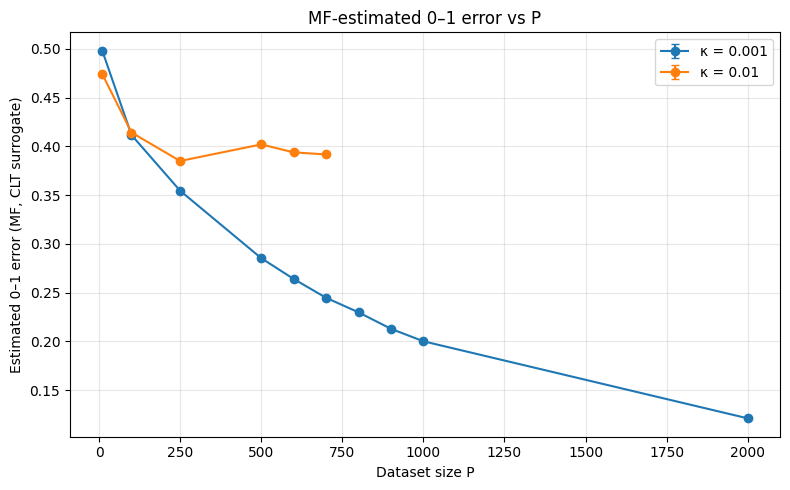

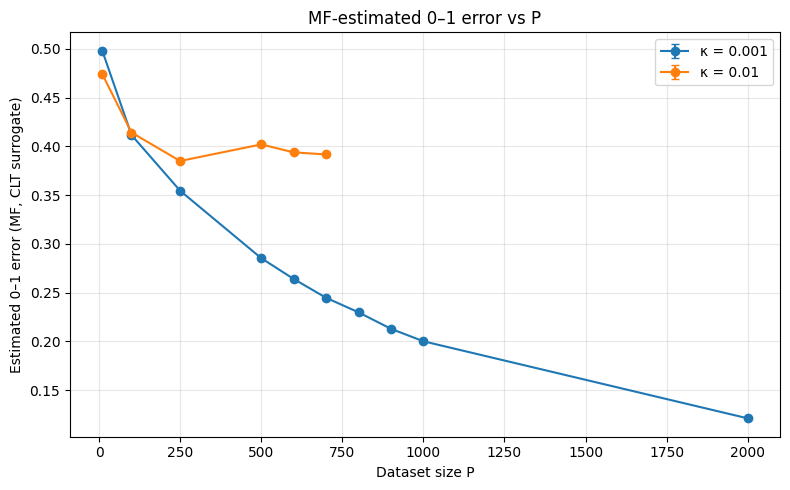

In [2]:
# === MF 0–1 error plotter (notebook-friendly) ===
import os, re, json, math, glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def phi_cdf(x: float) -> float:
    """Standard normal CDF without SciPy."""
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def parse_meta_from_filename(path):
    """
    Extract kappa, P, M_noise from filenames like:
      ..._kap1.000e-03_P750_K4_M2048_it4000_B1024.json
    Returns (kappa_float, P_int, M_noise_int) or (None, None, None).
    """
    fname = os.path.basename(path)
    mk = re.search(r"_kap([0-9eE\+\-\.]+)", fname)
    mp = re.search(r"_P(\d+)", fname)
    mm = re.search(r"_M(\d+)", fname)
    try:
        kappa = float(mk.group(1)) if mk else None
        P = int(mp.group(1)) if mp else None
        M_noise = int(mm.group(1)) if mm else None
        return kappa, P, M_noise
    except Exception:
        return None, None, None

def estimate_err01_from_file(path, iter_index=-1, vnoise_floor=1e-16):
    """
    Estimate MF 0–1 error for one JSON file at a chosen iteration (default: final).
    Uses CLT surrogate: err ≈ Φ( - mS / sqrt(V_noise) ), where V_noise = M_noise * RMS_noise^2.
    Returns dict or None on failure.
    """
    kappa, P, M_noise = parse_meta_from_filename(path)
    try:
        with open(path, "r") as f:
            data = json.load(f)
    except Exception:
        return None

    # Try to fill missing metadata from JSON (kappa, P); M_noise must come from filename
    if kappa is None:
        kappa = data.get("summary", {}).get("kappa", None)
    if P is None:
        P = data.get("summary", {}).get("P", None)
    if (kappa is None) or (P is None) or (M_noise is None):
        return None

    traj = data.get("trajectories", {})
    mS_per_iter = traj.get("m_S_per_iter", None)
    noise_rms_per_iter = traj.get("m_noise_rms_per_iter", None)
    if not mS_per_iter or not noise_rms_per_iter:
        return None

    try:
        mS = np.array(mS_per_iter[iter_index], dtype=float)      # shape: (blocks,)
        rms = np.array(noise_rms_per_iter[iter_index], dtype=float)
    except Exception:
        return None

    good = np.isfinite(mS) & np.isfinite(rms)
    if not np.any(good):
        return None
    mS = mS[good]
    rms = rms[good]

    # V_noise = sum_{A≠S} m_A^2 = (M_noise) * (RMS_noise)^2
    V_noise = (M_noise) * (rms ** 2)
    V_noise = np.maximum(V_noise, vnoise_floor)

    snr = mS / np.sqrt(V_noise)
    err01 = np.array([phi_cdf(-float(s)) for s in snr], dtype=float)

    return {
        "kappa": float(kappa),
        "P": int(P),
        "M_noise": int(M_noise),
        "err01_block_mean": float(err01.mean()),
        "err01_block_std": float(err01.std(ddof=0)),
        "n_blocks": int(err01.size),
        "file": path,
    }

def aggregate_by_kappa_P(rows):
    """
    Aggregate rows with the same (kappa, P) by weighting their means by #blocks.
    Returns list of aggregated dicts.
    """
    groups = defaultdict(list)
    for r in rows:
        groups[(r["kappa"], r["P"])].append(r)

    agg = []
    for (kappa, P), rs in groups.items():
        weights = np.array([r["n_blocks"] for r in rs], dtype=float)
        vals = np.array([r["err01_block_mean"] for r in rs], dtype=float)
        mean = float(np.average(vals, weights=weights))
        std_over_runs = float(np.std(vals, ddof=0))   # variability across files
        total_blocks = int(np.sum(weights))
        M_noise = rs[0]["M_noise"]
        agg.append({
            "kappa": float(kappa),
            "P": int(P),
            "M_noise": int(M_noise),
            "err01_mean": mean,
            "err01_std_over_runs": std_over_runs,
            "n_runs": len(rs),
            "total_blocks": total_blocks,
        })
    return agg

def plot_err_vs_P(agg_rows, title=None):
    """
    Plot err01_mean vs P, color-coded by kappa. Returns (fig, ax).
    """
    by_kappa = defaultdict(list)
    for r in agg_rows:
        by_kappa[r["kappa"]].append(r)

    fig, ax = plt.subplots(figsize=(8, 5))
    for kappa in sorted(by_kappa.keys()):
        rows = sorted(by_kappa[kappa], key=lambda r: r["P"])
        Ps = [r["P"] for r in rows]
        errs = [r["err01_mean"] for r in rows]
        yerr = [r["err01_std_over_runs"] for r in rows]
        label = f"κ = {kappa:g}"
        ax.errorbar(Ps, errs, yerr=yerr, capsize=3, marker="o", linestyle="-", label=label)

    ax.set_xlabel("Dataset size P")
    ax.set_ylabel("Estimated 0–1 error (MF, CLT surrogate)")
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig, ax

def make_plot_from_dir(results_dir, iter_index=-1, save_png=True, png_name="mf_estimated_01_vs_P.png"):
    """
    Scan a directory for *.json, compute MF 0–1 error per file (final iter by default),
    aggregate by (kappa,P), and plot.
    """
    paths = glob.glob(os.path.join(results_dir, "*.json"))
    rows = []
    for p in paths:
        r = estimate_err01_from_file(p, iter_index=iter_index)
        if r is not None:
            rows.append(r)

    if not rows:
        print("No usable JSON files found (or unable to parse κ, P, M_noise).")
        return None

    agg = aggregate_by_kappa_P(rows)

    # Console summary (nice in notebooks too)
    print("Aggregated by (κ, P):")
    for r in sorted(agg, key=lambda t: (t["kappa"], t["P"])):
        print(f"  κ={r['kappa']:g}  P={r['P']:>6d}  "
              f"err01_mean={r['err01_mean']:.4f}  runs={r['n_runs']}  "
              f"blocks={r['total_blocks']}  M_noise={r['M_noise']}")

    fig, ax = plot_err_vs_P(agg, title="MF-estimated 0–1 error vs P")

    if save_png:
        out_png = os.path.join(results_dir, png_name)
        fig.savefig(out_png, dpi=150)
        print(f"[saved plot] {out_png}")

    return {"agg": agg, "fig": fig, "ax": ax}

# ==== Example usage (Notebook) ====
# Set your directory with saved JSONs:
results_dir = "/home/goring/mean_field_langevin/MCMC_finiteP/results/2208_grid_infN_full"
out = make_plot_from_dir(results_dir, iter_index=-1, save_png=False)
out["fig"]  # shows inline in a notebook
